# Navigating Through The Unknown
<hr style="border:2px solid black"> </hr>

<b>Description: <br></b>
In this notebook we will implement a vector Kalman filter that tracks an object moving with constant velocity using a position sensor.<br><br>
<b>Tasks:<b><br>
1. Creating & sensing the moving object
2. Tracking the moving object

## Libraries
Here, we define the libraries used in the project

In [1]:
#import numpy for numerical calculations
import numpy as np
#import matplotlib fot plots
import matplotlib.pyplot as plt

## Creating & Sensing Moving Objects
We will not use real data from real sensors, so fake data are required. However, fake data should look "realistic". There are two things to considere about sensing moving objects in real life.
1. Plant Noise : Objects moving at constant velocity don't really move at constant velocity, their motion is "noisy". This can be due to many factors, like poor battery or poor control system.
2. Instrument Noise : Sensors don't capture object's exact velocity, sensing systems introduce noise to the measurements. One contributing factor to this noise is thermal noise caused by moving electrons within the sensor circuit.
### Moving Object
We start by creating the object we want to track <br>
This will include:
1. Defining the initial position of the object.
2. Defining the constant speed of the object.
3. Defining the sampling frequency/period of measurements.
4. Defining the number of samples we will take.
5. Adding noise sampled data, simulating plant noise.

In [2]:
#define initial position
pos_x_0, pos_y_0 = 0.0, 0.0
#define velocity
vel_x, vel_y = 2.0, 1.0
#define sampling frequency
fs = 1.0
#define number of samples
samples_num = 20

Calcualte the position of the moving object can be done using law of motion. Recall that velocity is constant in this scenario.

$$
x(t) = \frac{1}{2} a_x t^2 + v_x t + x_0
$$

$$
y(t) = \frac{1}{2} a_y t^2 + v_y t + y_0
$$

In [3]:
#calcualte the ideal object position
x_ideal = np.array([pos_x_0 + fs*i*vel_x for i in range(0, samples_num)], np.float64)
y_ideal = np.array([pos_y_0 + fs*i*vel_y for i in range(0, samples_num)], np.float64)

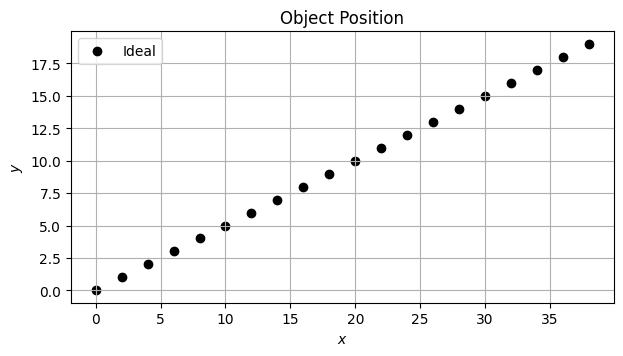

In [4]:
fig, ax = plt.subplots(figsize=[7, 7])
ax.set_aspect("equal", "box")
ax.scatter(x_ideal, y_ideal, color="k")
ax.grid()
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Object Position")
ax.legend(["Ideal"])

Add (Gaussian) plant noise.

In [5]:
#define plant noise power
plant_noise_power = 0.5
#add plant noise to "ideal" object positions
x_plant = x_ideal + np.random.normal(0, plant_noise_power, samples_num)
y_plant = y_ideal + np.random.normal(0, plant_noise_power, samples_num)

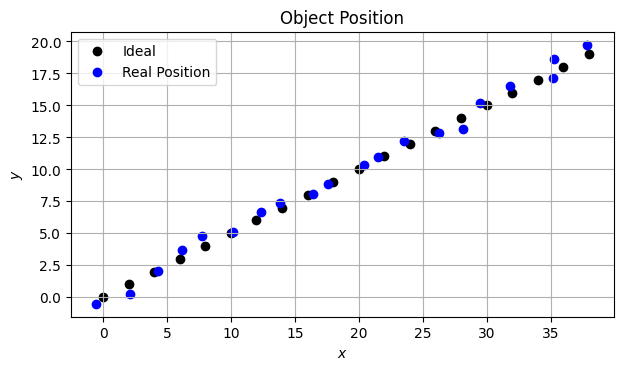

In [6]:
fig, ax = plt.subplots(figsize=[7, 7])
ax.set_aspect("equal", "box")
ax.scatter(x_ideal, y_ideal, color="k")
ax.scatter(x_plant, y_plant, color="b")
ax.grid()
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Object Position")
ax.legend(["Ideal", "Real Position"])

### Noisy Measurements
In this section we will create out noisy measurements of the object we are trying to track.
Sensor measurements are noisy. This noise can be considered normal/Gausian. <br>
<br>
<b>Assumption</b> : 
1. We assume that the noise in position measurement in x and y directions are independent of each other.
2. We also assume that the noise is zero mean, white, and Gaussian 
Then we will calculate the niosy measurements of object position

In [7]:
instrument_noise_power = 1.0
x_measure = x_plant + np.random.normal(0, instrument_noise_power, samples_num)
y_measure = y_plant + np.random.normal(0, instrument_noise_power, samples_num)

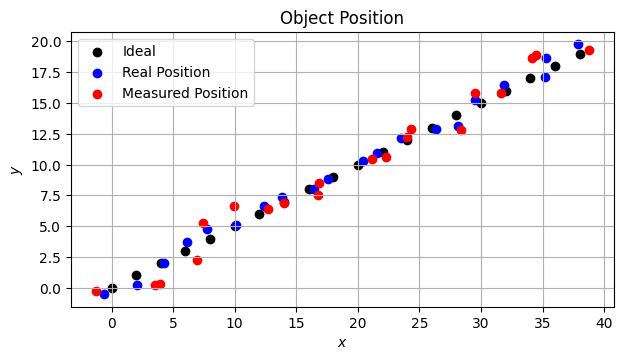

In [8]:
fig, ax = plt.subplots(figsize=[7, 7])
ax.set_aspect("equal", "box")
ax.scatter(x_ideal, y_ideal, color="k")
ax.scatter(x_plant, y_plant, color="b")
ax.scatter(x_measure, y_measure, color="r")
ax.grid()
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Object Position")
ax.legend(["Ideal", "Real Position", "Measured Position"])

Notice that the measured position by the sensor is quite far from the ground truth position.

## Tracking the Object

In this section we want to use the measurements to track the moving object usnig a Kalman filter.<br>

### The Vector Kalman Filter

First of all, we want to define the state vector, this defines the parameters we're interested in estimating, position and velocity. Velocity is needed as the object is moving with constant velocity, and physics tells us that knowing the velocty will allow us to know the next position.

$$
    \textbf{x} = 
    \begin{bmatrix}
    x \\
    \dot{x} \\
    y \\
    \dot{y}
    \end{bmatrix}
$$

where $\dot{x}$ is the rate of change of position, a.k.a. velocity. Also, notice that $\textbf{x}$ is the state vector and $x$ is the position along the x-axis.

The equation used to estimate the current state using a Kalman filter is shown below. This tells us how we can use the previous state estimation to predict the current state. It also uses the current observation to correct the error in estimations.

$$
    \hat{\textbf{x}}(n) = \textbf{A}\hat{\textbf{x}}(n-1) + \textbf{K}(n) (\textbf{y}(n) - \textbf{C} \textbf{A} \hat{\textbf{x}}(n-1))
$$

We have the state transition matrix, $\textbf{A}$, that is used to tell us the relationship between the current state and the previous state. These equations are derived from the physics of the problem (equations of motion).

$$
x(n) = x(n-1) + v_x T \\
v_{x}(n) = v_{x}(n-1) \\
y(n) = y(n-1) + v_y T \\
v_{y}(n) = v_{y}(n-1) \\
$$

$$
    \textbf{A} = 
    \begin{bmatrix}
    1 & T & 0 & 0 \\
    0 & 1 & 0 & 0 \\
    0 & 0 & 1 & T \\
    0 & 0 & 0 & 1
    \end{bmatrix}
$$



Then we can look at the observation equation. This equation ties what we observe with what we estimate. We are estimating velocity and position, but we are only observing position. This allows us to know more about the observation matrix, as it should extract the position estimations from the state estimation.

$$
    \textbf{C} = \begin{bmatrix}
    1 & 0 & 0 & 0 \\
    0 & 0 & 1 & 0
    \end{bmatrix}
$$

In [9]:
T = 1/fs
#define the state transition matrix
A = np.array([
    [1, T, 0,0],
    [0, 1, 0, 0],
    [0, 0, 1, T],
    [0, 0, 0, 1]
], np.float64)
#define the observation matrix
C = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0]
], np.float64)

It is good to note that these two matrices are always constant and they do not change for all estimations (unless we change the sampling frequency which will change T).

The remaining thing is the Kalman gain, $\textbf{K}(n)$, which can also be calculated recursively. The Kalman gain is the parameter that allows us to respond to the difference between our estimation and observation and reduces it. We have two equations to calculate the Kalman gain. 

$$
    \textbf{P}_1(n) = \textbf{A} \textbf{P}(n-1) \textbf{A}^\textbf{T} + \textbf{Q}
$$


In [10]:
def get_curr_pred_error_cov_matrix(prev_error_cov_matrix, plant_noise_cov_matrix):
    P_1 = np.dot(A, np.dot(prev_error_cov_matrix, A.T) ) + plant_noise_cov_matrix
    return P_1

$$
    \textbf{K}(n) = \textbf{P}_1(n) \textbf{C} [\textbf{C} \textbf{P}_1(n) \textbf{C}^T + \textbf{Z}]^{-1}
$$



Here we should note that $\textbf{P}_1(n)$ is the prediction error covariance matrix, $\textbf{P}(n)$ is the error covariance matrix, and $\textbf{Z}$ is the observation error covariance matrix. The error covariance matrix should also be updated at the end of each computation to make it ready for the next computation to take place.

$$
    \textbf{P}(n) = ( \textbf{I} - \textbf{K}(n) \textbf{C} ) \textbf{P}_1(n)
$$

In [11]:
def get_kalman_gain(prev_error_cov_matrix, plant_noise_cov_matrix,obs_error_cov_matrix):
    curr_pred_error_cov_matrix = get_curr_pred_error_cov_matrix(prev_error_cov_matrix, plant_noise_cov_matrix)
    K = curr_pred_error_cov_matrix@C.T@(np.linalg.inv(C@curr_pred_error_cov_matrix@(C.T) + obs_error_cov_matrix))
    curr_error_cov_matrix = (np.eye(len(K)) - K@C)@curr_pred_error_cov_matrix
    return K, curr_error_cov_matrix

There are also two noise covariance matrices, $\textbf{Q}$ and $\textbf{Z}$. $\textbf{Q}$ refers to the plant noise covariance matrix, this is the noise term representing the fluctuations in the plant process. In the car moving with contant velocity, this will be the fluctuations in velocity as a real car will not always move with constant velocity so we use this term, $\textbf{Q}$, to represent this. This phenomena can be mathematically represented as the change from the previous state with an added Gaussian noise term, $\textbf{g}$, that represents the random flutuations.

$$
\textbf{x}(n) = \textbf{x}(n-1) + \textbf{g}(n)
$$

$$
\textbf{Q} = E[\textbf{g}(n) + \textbf{g}^T(n)]
$$

$\textbf{Z}$ refers to the observation noise covariance matrix, this noise term represents the noise added to the measurements from our measuring system/sensor. This depends on the sensors we're using, we also assume that the noise in measuring x and y coordinates are independent of each other.

In [12]:
Q = np.array([
        [0, 0.02, 0, 0],
        [0.02, 0.02, 0, 0],
        [0, 0, 0, 0.02],
        [0, 0, 0.02, 0.02]
    ], np.float64) * plant_noise_power

Z = np.array([
        [1.0, 0],
        [0, 1.0]
    ], np.float64) *instrument_noise_power

We can now use the Kalman filter equation to estimate the current state.

$$
    \hat{\textbf{x}}(n) = \textbf{A}\hat{\textbf{x}}(n-1) + \textbf{K}(n) (\textbf{y}(n) - \textbf{C} \textbf{A} \hat{\textbf{x}}(n-1))
$$

In [13]:
def predict_state(prev_x, K, y):
    curr_x_hat = A@prev_x + K @ (y - C@A@prev_x)
    return curr_x_hat

Before starting the Kalman filter, we need to initialize the state matrix, $\textbf{x}$. We have to wait until we get at least two measurements to estimate initial position and velocity.

In [14]:
#start estimating from the 3rd measurement.
start_point = 2
#initial position
x_axis_0 = x_measure[1]
y_axis_0 = x_measure[1]
#initial velocity
vx_0 = np.mean([x_measure[0:2]])
vy_0 = np.mean([y_measure[0:2]])
#initialize state matrix
x_initial = np.array([x_axis_0, vx_0, y_axis_0, vy_0]).T
x_hat = np.zeros([4,len(x_measure)])
x_hat[:,1] = x_initial

##### Note:
The code below will be cleaned

In [15]:
#now do the noise and estimation matrices to start perdictions
P_prev = np.array([
        [np.var(x_measure[0:2]), 0, 0, 0],
        [0, np.var(x_measure[0:2]), 0, 0],
        [0, 0, np.var(y_measure[0:2]), 0],
        [0, 0, 0, np.var(y_measure[0:2])]
],np.float64)

K = np.array([], np.float64)

In [16]:
y_observed = np.zeros([2,samples_num])
y_observed[0] = x_measure
y_observed[1] = y_measure

In [17]:
for i in range(start_point, len(x_measure)):
    K, P_calc = get_kalman_gain(P_prev, Q,Z)
    x_kalman = predict_state(x_hat[:,i-1].T, K, y_observed[:,i])
    x_hat[:,i] = x_kalman
    P_prev = P_calc

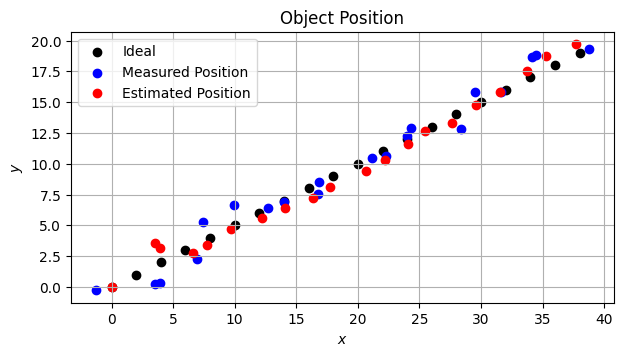

In [18]:
fig, ax = plt.subplots(figsize=[7, 7])
ax.set_aspect("equal", "box")
ax.scatter(x_ideal, y_ideal, color="k")
ax.scatter(x_measure, y_measure, color="b")
ax.scatter(x_hat[0], x_hat[2], color="r")
ax.grid()
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Object Position")
ax.legend(["Ideal", "Measured Position", "Estimated Position"])

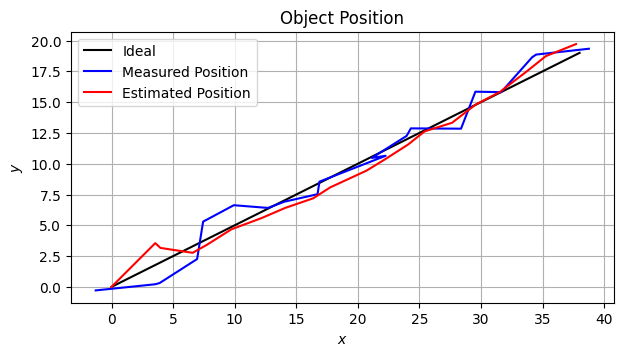

In [19]:
fig, ax = plt.subplots(figsize=[7, 7])
ax.set_aspect("equal", "box")
ax.plot(x_ideal, y_ideal, color="k")
ax.plot(x_measure, y_measure, color="b")
ax.plot(x_hat[0], x_hat[2], color="r")
ax.grid()
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Object Position")
ax.legend(["Ideal", "Measured Position", "Estimated Position"])

##### Conclusion:
It is clear from the scatter plot and the line graph that the estimated position is much closer to the ideal position. This shows that Kalman filters work!! Also, notice that even when the measured position is fluctuating, the estimated position doesn't fluctuate that much. The more samples we get, the more accurate estimations we make.

## Future tasks:
This work has shown the effectiveness of Klaman filters. Here are few more things you can do if you're more interested:
* Implement the filter in more examples. One example can be temperature measurements.
* Read about higher-order Kalman filters. 
* If you are really interested in adaptive filtering algorithms, you can read about particle filters.